In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(123)

# Multi-layer Perceptron : A Basic Neural Network

this is a simple `python+numpy` implementation of a feed-forward neural network based on [my MLPy repo](https://github.com/SNUDerek/MLPy)

![mlp diagram](https://www.researchgate.net/profile/Michael_Frish/publication/241347660/figure/fig3/AS:298690993508361@1448224890429/The-structure-of-a-multilayer-perceptron-neural-network.png)

_from Faghfouri and Frish, 2011_

# Concept

a neural network is trained with **Gradient Descent** in the same manner as Linear and Logistic Regression:

Until convergence:  
1. initialize weights randomly
2. make a prediction ( _Forward Propagation_ )
3. measure error ( e.g. cross-entropy / negative log-likelihood )
4. adjust weights ( _Backpropagation_ )

### forward propagation

this is a case of using the current weights to 'multiply and sum through' to get the outputs.

it's easier to view it from the perspective of the hidden layer neuron inputs:

1. each hidden neuron takes a _weighted sum_ of the inputs `x` times weights `w`: `sum(x * w) = u`
2. this is a dot product: inputs.dot(neuron_weights): `[A, B, C].dot([x, y, z]) = Ax + By + Cz`
3. then, this sum is (often) run through an activation function such as sigmoid, ReLU `σ(u) = h`
4. now, we have the (first) hidden layer activations, an array `[h0, h1, h2 ...]`
5. we now to the same process for the next layer(s) until we get the final outputs `o`

NB: because for *each* neuron of the hidden and output layers, the results of the previous layer are *summed*, this is how we can have layers with different numbers of neurons.

Also, we can see why we need randomized weights for the hidden neurons, because if the weights for each neuron were the same, then the `inputs * weights` would be the same, so the sums would be the same. by randomizing, each hidden neuron is learning to detect a (hopefully) *different* feature. 

## backwards propagation (backprop)

hehe gonna have to consult the resources below...

# NumPy example

### minbatch generator function

this is an iterator function that will return shuffled minibatches when called.  
`np.random.permutation()` takes a max-length integer, and returns a list of randomized indices between 0 and max_len.  
for each iteration, we return batches of `batch_size`, getting the data indices from this shuffled list.  
when the next batch would go past the end of the data, we generate a new list and start from the beginning again.

In [2]:
# return minibatches of data (for SGD)
def batchGenerator(x_data, y_data, batch_size):
    i = 0
    # shuffle indices
    order = np.random.permutation(len(y_data))

    # return the next batch_size number of data
    while True:
        x_batch = x_data[order[i:i + batch_size]]
        y_batch = y_data[order[i:i + batch_size]]

        yield (x_batch, y_batch)

        # if the next batch is beyond the data size,
        # reset the counter and re-shuffle the data
        if i + batch_size >= len(y_data) - 1:
            order = np.random.permutation(len(y_data))
            i = 0
        else:
            i += batch_size

# MLP class

this is a simple class-based implementation of a Multi-Layer Perceptron.  
it's a type of Dense neural network with at least one hidden layer.  
we will use the **sigmoid activation** on all layers, just like our logistic regression example.  
(although keep in mind that this is a largely outdated activation: use a ReLU variant)  

for our loss we are using the simple negative log-likelihood or binary cross-entropy loss.  
this means our output can be any combination of values between `0,1`  
so our network can be used for *multi-label* classification, among other things.  
we will use a simple implementation of the **bias** similar to the image above:  
no bias will be added at hidden layers 2+, although `addbias` can add a column of 1's to act as hidden layer 1 bias  

if we wanted better perfomance for strict *multi-class* classification with mutually-exclusive ("one-hot") outputs,  
we should implement `softmax activation` for the hidden layer activation, and `categorical cross-entropy loss`  

In [3]:
# multilayer perceptron from MLPy (https://github.com/SNUDerek/MLPy)
# adapted from https://databoys.github.io/Feedforward/
# and https://www.analyticsvidhya.com/blog/2017/05/neural-network-from-scratch-in-python-and-r/
class MultiLayerPerceptron:

    def __init__(self, input_dim, hidden_dim, output_dim, hidden_layers=1, addbias=True,
                 epochs=1000, batch_size=16, lr=0.001, print_iters=1000, verbose=False):
        '''
        Multi-Layer Perceptron with Sigmoid Activation and Binary Cross-Entropy Loss
        for multi-class and multi-label tasks
        Parameters
        ----------
        input_dim : int
            number of input features - set by X.shape[1]
        hidden_dim : int
            number of features (neurons) in each hidden layer - set manually
        output_dim : int
            number of output features (classes) - set by y.shape[1]
        hidden_layers : int
            number of hidden layers
        addbias : bool
            whether to add a bias to the input variable
        epochs : int
            maximum epochs
        batch_size : int
            number of samples per batch for minibatch gradient descent
        lr : float
            learning rate
        print_iters : int
            how many iters between cost printout (if verbose)
        verbose : bool
            whether to print intermediate cost values during training
        weights : array
            weights (coefficients) of linear model
        Attributes
        -------
        costs : list of floats
            the binary cross-entropy costs per epoch
        errors : list of floats
            the averaged sum of absolute difference (pred - true) per epoch
        wh : list of np.arrays
            the weight vectors for each hidden layer
        wout : np.array
            the weight vector for the output layer
        '''

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.hidden_lyr = hidden_layers
        self.addbias = addbias
        self.epochs = epochs
        self.batchsize = batch_size
        self.lr = lr
        self.print_iters = print_iters
        self.verbose = verbose
        if self.addbias:
            self.input_dim += 1
        # initialize weights, activations
        # initialize randomly so each learns something different
        # input weights are not considered
        self.h_acts = [np.zeros((self.hidden_dim, self.batchsize)) for l in range(self.hidden_lyr)]
        self.wh = [np.random.uniform(size=(self.input_dim, self.hidden_dim))]
        for l in range(self.hidden_lyr - 1):
            self.wh.append(np.random.uniform(size=(self.hidden_dim, self.hidden_dim)))
        self.wout = np.random.uniform(size=(self.hidden_dim, self.output_dim))
        self.costs = []
        self.errors = []

    # internal function for sigmoid
    def _sigmoid(self, estimates):

        sigmoid = 1 / (1 + np.exp(-estimates))

        return sigmoid

    # internal function for derivative of sigmoid
    # sigmoid(y) * (1.0 - sigmoid(y))
    def _dsigmoid(self, sig_y):

        deriv = sig_y * (1.0 - sig_y)

        return deriv

    # Forward Propagation
    def _feedforward(self, x_batch):

        for i in range(self.hidden_lyr):

            # multiply previous layer outputs by the weights
            if i == 0:
                hidden_layer_input = np.dot(x_batch, self.wh[i])
            else:
                hidden_layer_input = np.dot(self.h_acts[i-1], self.wh[i])

            # run the activations though non-linearity
            self.h_acts[i] = self._sigmoid(hidden_layer_input)

        # calculate final output layer
        output_layer_input = np.dot(self.h_acts[self.hidden_lyr-1], self.wout)
        output = self._sigmoid(output_layer_input)

        return output

    # cross-entropy cost function
    def _cost(self, y, t):
        return - np.sum(np.multiply(t, np.log(y)) + np.multiply((1 - t), np.log(1 - y)))

    # Backpropagation
    def _backprop(self, x_batch, y_batch, hidden_layer_acts, output):

        # calculate output error
        output_error = y_batch - output
        grad_output_layer = self._dsigmoid(output)
        delta_output = output_error * grad_output_layer

        # propagate error, delta for each hidden layer
        grad_hidden_layer = [[] for i in range(self.hidden_lyr)]
        hidden_error = [[] for i in range(self.hidden_lyr)]
        delta_hidden_layer = [[] for i in range(self.hidden_lyr)]

        for i in range(len(hidden_layer_acts)):
            # BACK-propagate from the last layer (count backwards!)
            idx = len(hidden_layer_acts) - (i + 1)
            grad_hidden_layer[idx] = self._dsigmoid(hidden_layer_acts[idx])

            if i == 0:
                hidden_error[idx] = delta_output.dot(self.wout.T)
            else:
                hidden_error[idx] = delta_hidden_layer[idx+1].dot(self.wh[idx+1].T)

            delta_hidden_layer[idx] = hidden_error[idx] * grad_hidden_layer[idx]

        # weight updates for all layers
        self.wout += hidden_layer_acts[-1].T.dot(delta_output) * self.lr
        for i in range(len(hidden_layer_acts)):
            if i == 0:
                self.wh[i] += x_batch.T.dot(delta_hidden_layer[i]) * self.lr
            else:
                self.wh[i] += hidden_layer_acts[i - 1].T.dot(delta_hidden_layer[i]) * self.lr

        return output_error

    # add a 'train' function for keras-type naming convention
    def train(self, x_data, y_data):

        self.fit(x_data, y_data)

        return

    # main fitting function
    def fit(self, x_data, y_data):

        # reset costs from previous fittings
        self.costs = []
        self.errors = []

        # re-initialize weight matrices
        self.h_acts = [np.zeros((self.hidden_dim, self.batchsize)) for l in range(self.hidden_lyr)]
        self.wh = [np.random.uniform(size=(self.input_dim, self.hidden_dim))]
        for l in range(self.hidden_lyr - 1):
            self.wh.append(np.random.uniform(size=(self.hidden_dim, self.hidden_dim)))
        self.wout = np.random.uniform(size=(self.hidden_dim, self.output_dim))

        # add 1 for bias term
        if self.addbias:
            x_data = np.hstack((np.ones((x_data.shape[0], 1)), x_data))

        # generator for minibatch gradient descent
        minibatch = batchGenerator(x_data, y_data, self.batchsize)

        # for each epoch (through all data)
        for i in range(self.epochs):

            costs = []

            # for the number of minibatches per epoch:
            for j in range(int(len(y_data)/self.batchsize)):

                x_batch, y_batch = next(minibatch)

                output = self._feedforward(x_batch)

                costs.append(self._cost(output, y_batch))

                out_error = self._backprop(x_batch, y_batch,
                                           self.h_acts, output)

                # sub the absolute values of the errors
                error = np.sum(np.absolute(out_error))

            if self.verbose and i % self.print_iters == 0:
                print('epoch', i, ': cross-entropy cost %-.5f' % np.average(costs), ': sum abs error %-.5f' % error)

            self.costs.append(np.average(costs))
            self.errors.append(error)

        return

    # predict_proba outputs the raw activations
    def predict_proba(self, x_data):

        # add 1 for bias term
        if self.addbias:
            x_data = np.hstack((np.ones((x_data.shape[0], 1)), x_data))

        predictions = self._feedforward(x_data)

        return predictions

    # predict rounds the outputs to 0 or 1
    def predict(self, x_data):

        pred_probas = self.predict_proba(x_data)

        predictions = np.around(pred_probas)

        return predictions


# Universal Approximation Property

the neural network has been shown to be a _universal function approximator_ : given a continuous function, there is some neural network that can approximate this function to an arbitrary level of accuracy. essentially, this means that the neural network can be applied to a variety of tasks. we will try applying our simple neural network code to a variety of tasks below. 

for an explanation of this universal function approximator property, see the links below:  
(easy interactive demo) Nielsen: [A visual proof that neural nets can compute any function](http://neuralnetworksanddeeplearning.com/chap4.html)  
(one mathematical proof) McNeela: [The Universal Approximation Theorem for Neural Networks](http://mcneela.github.io/machine_learning/2017/03/21/Universal-Approximation-Theorem.html)

## example 1: function approximation

here we will attempt to replicate the function approximation by mapping a polynomial function f(x) = ...

In [4]:
# a polynomial equation
def myFunction(x):
    return 0.3 * x**4 + 0.6 * x**3 - 3.5 * x**2 - 5.5 * x + 10

In [5]:
x_data = []
y_data = []
for i in range(1000):
    # sample random x value
    x = np.random.uniform(-4, 3)
    y = myFunction(x)
    x_data.append(x)
    y_data.append(y)

In [6]:
np.min(x_data), np.max(x_data), np.min(y_data), np.max(y_data)

(-3.9994267867043263,
 2.9924288418095832,
 -5.633023358439807,
 14.385389007349342)

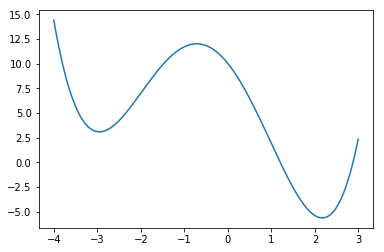

In [7]:
order = np.argsort(x_data)
x_data = np.array(x_data)[order]
y_data = np.array(y_data)[order]
plt.plot(x_data, y_data)

In [8]:
# normalize both axes to range 0, 1
x_data += np.abs(np.min(x_data)) # raise up values to 0.0+
x_data /= np.max(np.abs(x_data), axis=0) # then divide each value by max
y_data += np.abs(np.min(y_data))
y_data /= np.max(np.abs(y_data), axis=0)

In [9]:
# check
np.min(x_data), np.max(x_data), np.min(y_data), np.max(y_data)

(0.0, 1.0, 0.0, 1.0)

as we can see below, the representation of the function hasn't changed, just the scale

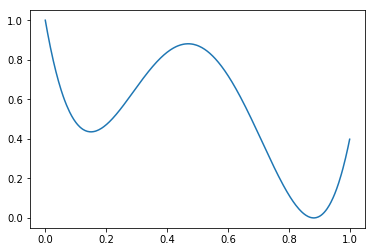

In [10]:
# need to reorder for matplotlib
order = np.argsort(x_data)
x_data = np.array(x_data)[order]
y_data = np.array(y_data)[order]
plt.plot(x_data, y_data)

In [11]:
# turn this data into "list of lists"
x_data = x_data[:, np.newaxis]
y_data = y_data[:, np.newaxis]
x_data.shape, y_data.shape

((1000, 1), (1000, 1))

In [29]:
# create an instance
# this model only has five neurons configured in one hidden layer
function_mlp = MultiLayerPerceptron(x_data.shape[1], 
                                    8, # hidden_dim 
                                    y_data.shape[1], 
                                    hidden_layers=1, 
                                    addbias=True,
                                    epochs=5000, 
                                    batch_size=4, 
                                    lr=0.05, 
                                    print_iters=500, 
                                    verbose=True)

In [30]:
costs = function_mlp.train(x_data, y_data)

epoch 0 : cross-entropy cost 2.92296 : sum abs error 1.08247
epoch 500 : cross-entropy cost 2.18954 : sum abs error 0.40731
epoch 1000 : cross-entropy cost 2.15563 : sum abs error 0.20610
epoch 1500 : cross-entropy cost 2.13691 : sum abs error 0.31064
epoch 2000 : cross-entropy cost 2.08644 : sum abs error 0.18758
epoch 2500 : cross-entropy cost 2.07386 : sum abs error 0.29018
epoch 3000 : cross-entropy cost 2.06875 : sum abs error 0.14956
epoch 3500 : cross-entropy cost 2.06447 : sum abs error 0.20392
epoch 4000 : cross-entropy cost 2.06063 : sum abs error 0.13332
epoch 4500 : cross-entropy cost 2.05746 : sum abs error 0.05108


In [31]:
# predict values - proba will give scaled values
y_pred = function_mlp.predict_proba(x_data)

### results

as we can see below, our neural network has learned how to approximate our function pretty well with only a few neurons in a single layer!

notice: we need to add bias to the hidden layer to help this converge well.

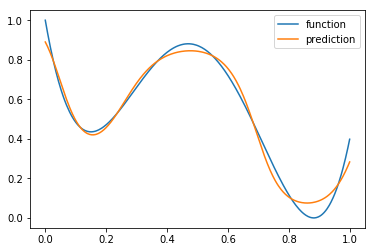

In [32]:
plt.plot(x_data, y_data, label='function')
plt.plot(x_data, y_pred, label='prediction')
plt.legend()

## example 2: counting in binary

we can teach a neural network to count in binary. our number system is base 10, meaning each digits place is a different power of ten: the 'ones' place is 10^0, tens is 10^1, hundreds is 10^2 etc. binary is base 2, meaning each 'place' is a power of 2:

```
1 = 2^0 = 0001
2 = 2^1 = 0010
3 = 2 + 1 = 2^1 + 2^0 = 0011
...
11 = 8 + 2 + 1 = 2^3 + 2^1 + 2^0 = 1011
```

therefore, using three values `[ x, x, x ]` we can represent the numbers 0 to 7 as `[0,0,0]` to `[1,1,1]`

we can then try to teach our network to output the next number given any number in the sequence

idea is taken from here: [Backpropagation Neural Network - How it Works e.g. Counting](https://www.youtube.com/watch?v=WZDMNM36PsM)

In [16]:
X = np.array([[0, 0, 0],  # 0
              [0, 0, 1],  # 1
              [0, 1, 0],  # 2
              [0, 1, 1],  # 3
              [1, 0, 0],  # 4
              [1, 0, 1],  # 5
              [1, 1, 0],  # 6
              [1, 1, 1]]) # 7

y = np.array([[0, 0, 1],
              [0, 1, 0],
              [0, 1, 1],
              [1, 0, 0],
              [1, 0, 1],
              [1, 1, 0],
              [1, 1, 1],
              [0, 0, 0]])

X.shape, y.shape

((8, 3), (8, 3))

In [17]:
# create an instance
counting_mlp = MultiLayerPerceptron(X.shape[1], 
                                    4, # hidden_dim 
                                    y.shape[1], 
                                    hidden_layers=2,
                                    addbias=True,
                                    epochs=100000, 
                                    batch_size=2, 
                                    lr=0.05, 
                                    print_iters=10000, 
                                    verbose=True)

In [18]:
costs = counting_mlp.train(X, y)

epoch 0 : cross-entropy cost 5.10204 : sum abs error 4.09369
epoch 10000 : cross-entropy cost 0.71166 : sum abs error 0.62248
epoch 20000 : cross-entropy cost 0.16890 : sum abs error 0.16604
epoch 30000 : cross-entropy cost 0.11862 : sum abs error 0.10801
epoch 40000 : cross-entropy cost 0.09704 : sum abs error 0.10977
epoch 50000 : cross-entropy cost 0.08424 : sum abs error 0.11607
epoch 60000 : cross-entropy cost 0.07549 : sum abs error 0.06725
epoch 70000 : cross-entropy cost 0.06903 : sum abs error 0.08594
epoch 80000 : cross-entropy cost 0.06399 : sum abs error 0.08578
epoch 90000 : cross-entropy cost 0.05993 : sum abs error 0.06098


In [19]:
# see results
good = 0
for i, x in enumerate(X):
    prd = counting_mlp.predict(np.array([x]))[0].astype(int)
    tru = np.array(y[i])
    if np.array_equal(prd, tru):
        good += 1
    print('x:', x, 'tru:', tru, 'prd:', prd, 'ok?:', np.array_equal(prd, tru))
print()
print('accuracy:', good*100/X.shape[0], '%')

x: [0 0 0] tru: [0 0 1] prd: [0 0 1] ok?: True
x: [0 0 1] tru: [0 1 0] prd: [0 1 0] ok?: True
x: [0 1 0] tru: [0 1 1] prd: [0 1 1] ok?: True
x: [0 1 1] tru: [1 0 0] prd: [1 0 0] ok?: True
x: [1 0 0] tru: [1 0 1] prd: [1 0 1] ok?: True
x: [1 0 1] tru: [1 1 0] prd: [1 1 0] ok?: True
x: [1 1 0] tru: [1 1 1] prd: [1 1 1] ok?: True
x: [1 1 1] tru: [0 0 0] prd: [0 0 0] ok?: True

accuracy: 100.0 %


## example 3: classification with the IRIS dataset

we will use the [iris flower dataset for classification](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) to test our network on a classification task.

the input for each sample contains **four features**: `Sepal Length, Sepal Width, Petal Length and Petal Width`

the output for each sample contains **three classes**: `Setosa, Versicolour, and Virginica`

we will use some helper functions from my full `MLPy` repo at https://github.com/SNUDerek/MLPy 

because this is a multi- *class* classification, we would be better off 

In [20]:
from mlpy.tools import accuracy_score, one_hot, train_test_split
from sklearn import datasets

In [21]:
iris = datasets.load_iris()
X = iris.data
y = np.asarray(iris.target)
y = one_hot(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [22]:
x_train.shape[1], y_train.shape[1], len(x_train), len(x_test)

(4, 3, 120, 30)

In [23]:
iris_mlp = MultiLayerPerceptron(x_train.shape[1], 
                                6, 
                                y_train.shape[1], 
                                hidden_layers=2, 
                                addbias=True,
                                epochs=5000, 
                                batch_size=4,
                                lr=0.01, 
                                print_iters=500, 
                                verbose=True)

In [24]:
iris_mlp.train(x_train, y_train)

epoch 0 : cross-entropy cost 21.31151 : sum abs error 7.55782
epoch 500 : cross-entropy cost 7.64645 : sum abs error 5.37060
epoch 1000 : cross-entropy cost 7.64541 : sum abs error 5.44812
epoch 1500 : cross-entropy cost 7.64864 : sum abs error 5.38869
epoch 2000 : cross-entropy cost 7.64869 : sum abs error 5.31746
epoch 2500 : cross-entropy cost 7.51949 : sum abs error 5.20944
epoch 3000 : cross-entropy cost 3.94935 : sum abs error 3.35061
epoch 3500 : cross-entropy cost 1.56626 : sum abs error 1.97487
epoch 4000 : cross-entropy cost 1.01274 : sum abs error 0.51327
epoch 4500 : cross-entropy cost 0.81513 : sum abs error 0.42292


In [25]:
y_pred = iris_mlp.predict_proba(x_test)

In [26]:
# we use argmax to get the top ONE highest value, and round the value in predictions to 1.0
y_test_idx = [np.argmax(v) for v in y_test]
y_pred_idx = [np.round(np.argmax(v)) for v in y_pred]

In [27]:
print(accuracy_score(y_test_idx, y_pred_idx))

0.9666666666666667


In [28]:
# miscats
for i in range(len(y_test_idx)):
    if y_test_idx[i] != y_pred_idx[i]:
        print(y_test_idx[i], y_pred_idx[i])

1 2


## resources

**python walkthroughs**  
Databoys: ["Neural network with numpy"](https://databoys.github.io/Feedforward/)  
Muellerklein: ["Neural network with numpy"](http://florianmuellerklein.github.io/nn/)  
Ray: ["Understanding and coding Neural Networks From Scratch in Python and R"](https://www.analyticsvidhya.com/blog/2017/05/neural-network-from-scratch-in-python-and-r/)  
Roelants: ["How to implement a neural network Part 3"](http://peterroelants.github.io/posts/neural_network_implementation_part03/) _and subsequent sections_  
Rolisz: ["Neural Networks in Python"](https://rolisz.ro/2013/04/18/neural-networks-in-python/)  

**backprop explanations**  
3Blue1Brown: *Deep Learning playlist* (video lectures):  
[Deep Learning CH1: But what IS a Neural Network?](https://www.youtube.com/watch?v=aircAruvnKk)  
[Deep Learning CH2: Gradient Descent, How Neural Networks Learn](https://www.youtube.com/watch?v=IHZwWFHWa-w&t=0s)  
[Deep Learning CH3: What is Backpropagation Really Doing?](https://www.youtube.com/watch?v=Ilg3gGewQ5U)  
[Deep Learning CH3 Appendix: Backpropagation Calculus](https://www.youtube.com/watch?v=tIeHLnjs5U8)  
Mazur: ["A Step by Step Backpropagation Example"](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/)  
McGonagle *et al.* [Brilliant: Backpropagation](https://brilliant.org/wiki/backpropagation/)  
Nielsen: [_Neural Networks and Deep Learning CH2_](http://neuralnetworksanddeeplearning.com/chap2.html)  

**expanded concepts:**  
Wolf: [Minimizing the Negative Log-Likelihood, in English](http://willwolf.io/2017/05/18/minimizing_the_negative_log_likelihood_in_english/)